In [44]:
!pip install mne-features

In [45]:
# importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import os
import math
from mne_features.univariate import compute_hurst_exp

In [46]:
# importing elpileptic and healthy data
def load_csv_files(directory):
    all_df = []    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            all_df.append(df)
    
    combined_df = pd.concat(all_df, ignore_index=True)   
    return combined_df

epi_directory = '/kaggle/input/epileptic'
healthy_directory = '/kaggle/input/healthy'

# loading epileptical data 
epi_data = load_csv_files(epi_directory)
# loading healthy data
heal_data = load_csv_files(healthy_directory)

In [47]:
def create_groups(data, group_size):
  groups = []
  for i in range(0, len(data), group_size):
    groups.append(data[i : i + group_size])
  return groups

In [48]:
# converting the dataframe into 2-D numpy-array
epi_modified_data = np.asarray(epi_data.T).flatten()[:33000000]
heal_modified_data = np.asarray(heal_data.T).flatten()[:22000000]
# adjusting sizes
epi_groups = create_groups(epi_modified_data, group_size = 3000)
heal_groups = create_groups(heal_modified_data, group_size = 2000)

In [49]:
epi_data.shape, heal_data.shape, len(epi_groups)

((1844925, 19), (1207161, 19), 11000)

### fourth feautre hurst exponent

In [50]:
def cal_hurst_exp(eeg_data):
    # Compute the hurst exponent
    hurst_exp = compute_hurst_exp(eeg_data)
    return hurst_exp

In [51]:
# calculating the feautre of epi and healthy data
epi_hurst_exp_feautre = []
for epi_group in epi_groups:
    epi_hurst_exp_feautre.append(cal_hurst_exp(np.expand_dims(epi_group, axis = 0)))
    
heal_hurst_exp_feautre = []
for heal_group in heal_groups:
    heal_hurst_exp_feautre.append(cal_hurst_exp(np.expand_dims(heal_group, axis = 0)))

In [52]:
len(epi_hurst_exp_feautre)

11000

In [83]:
he_obs = epi_hurst_exp_feautre
epi_obs = heal_hurst_exp_feautre

mean_he_obs = np.mean(he_obs)
mean_epi_obs = np.std(epi_obs)

s_d_he_obs = np.mean(he_obs)
s_d_epi_obs = np.std(epi_obs)

In [84]:
p_h0 =  (1/np.sqrt(2*np.pi*s_d_he_obs)) + np.exp(-0.5*((he_obs - mean_he_obs)/s_d_he_obs)**2)
p_h1 =  (1/np.sqrt(2*np.pi*s_d_epi_obs)) + np.exp(-0.5*((epi_obs - mean_epi_obs)/s_d_epi_obs)**2)

Text(0.5, 1.0, 'Probability Distribution Function of healthy vs epileptical')

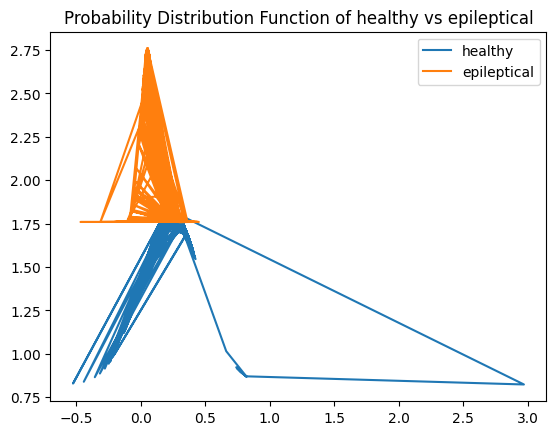

In [89]:
plt.plot(np.sort(he_obs), p_h0, label = 'healthy')
plt.plot(np.sort(epi_obs), p_h1, label = 'epileptical')
plt.legend()
plt.title('Probability Distribution Function of healthy vs epileptical')

In [73]:
# taking the log of the pdfs of epi and heal
p_h0_log =  np.log(1/np.sqrt(2*np.pi*s_d_he_obs)) + (-0.5*((he_obs - mean_he_obs)/s_d_he_obs)**2)
p_h1_log =  np.log(1/np.sqrt(2*np.pi*s_d_epi_obs)) + (-0.5*((epi_obs - mean_epi_obs)/s_d_epi_obs)**2)

# taking log LRT
ln_lrt = p_h1_log - p_h0_log

Text(0.5, 1.0, 'Probability Distribution Function of healthy vs epileptical')

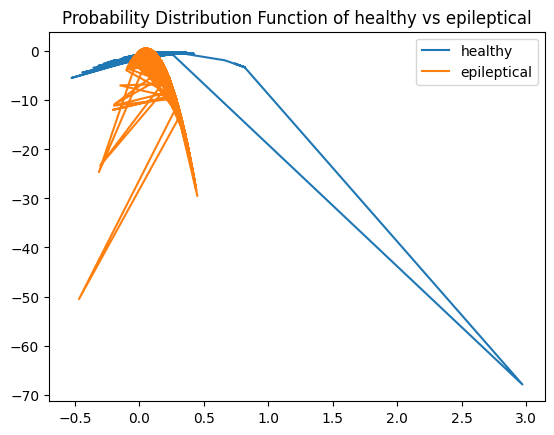

In [74]:
plt.plot(he_obs, p_h0_log, label = 'healthy')
plt.plot(epi_obs, p_h1_log, label = 'epileptical')
plt.legend()
plt.title('Probability Distribution Function of healthy vs epileptical')

In [75]:
# finding the threshold
thresh = np.median(ln_lrt)

# finding lrt of heal (h0) and epi(h1)
lrt_h1 = []
lrt_h0 = []
for i in ln_lrt:
    if i > thresh:
        lrt_h1.append(i)
    else : 
        lrt_h0.append(i)

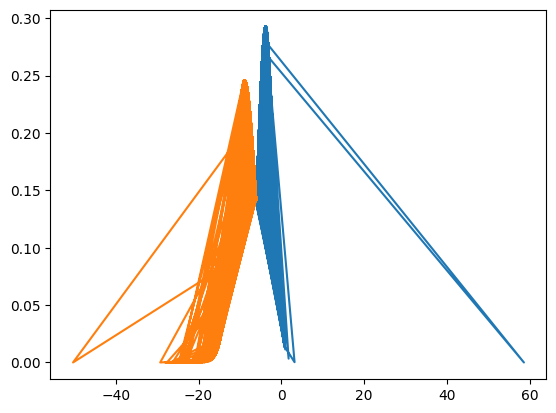

In [76]:
obs=(lrt_h1)
mean=np.mean(lrt_h1)
sigma=np.std(lrt_h1)

p_lrt_h1=(1/np.sqrt(2*np.pi*sigma))*np.exp(-0.5*((obs-mean)/sigma)**2)

obs=(lrt_h0)
mean=np.mean(lrt_h0)
sigma=np.std(lrt_h0)

p_lrt_h0=(1/np.sqrt(2*np.pi*sigma))*np.exp(-0.5*((obs-mean)/sigma)**2)

plt.plot(lrt_h1, p_lrt_h1)
plt.plot(lrt_h0, p_lrt_h0)

/tmp/ipykernel_33/69857043.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  threshold=np.arange(-20* abs(max(lrt_h0)),20*np.abs(max(lrt_h0)), 2*np.abs(max(lrt_h0))/len(lrt_h0))


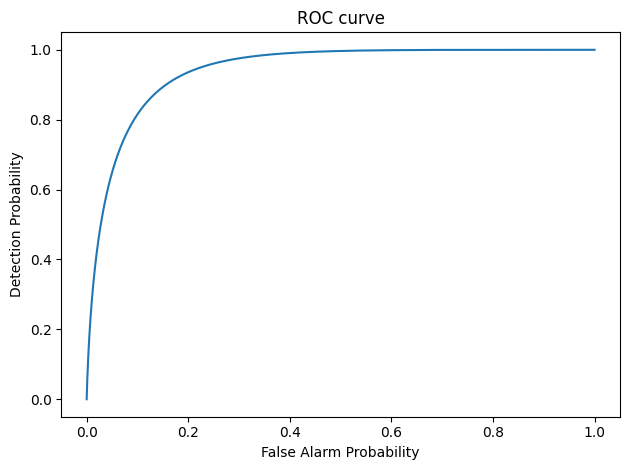

In [77]:
# plotting ROC curve
obs = (lrt_h1)
mean_pd = np.mean(lrt_h1)
sigma_pd = np.std(lrt_h1)

obs = (lrt_h0)
mean_pfa = np.mean(lrt_h0)
sigma_pfa = np.std(lrt_h0)

threshold=np.arange(-20* abs(max(lrt_h0)),20*np.abs(max(lrt_h0)), 2*np.abs(max(lrt_h0))/len(lrt_h0))
 
p_fa=[]
p_d=[]

for i in threshold:
    prob_false_alarm = 1 - norm.cdf(i, mean_pfa, sigma_pfa)
    p_fa.append(prob_false_alarm)
        
    prob_det = 1 - norm.cdf(i, mean_pd, sigma_pd)
    p_d.append(prob_det)

plt.plot(p_fa, p_d)
plt.xlabel("False Alarm Probability")
plt.ylabel("Detection Probability")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [78]:
np.unique(threshold).shape

(110001,)

In [79]:
def auc_from_pfa_pd(pfa, pd):
    # Sort (PFA, PD) pairs by increasing PFA
    sorted_indices = np.argsort(pfa)
    sorted_pfa = np.array(pfa)[sorted_indices]
    sorted_pd = np.array(pd)[sorted_indices]
    # Interpolate the ROC curve
    roc_curve = np.trapz(sorted_pd, sorted_pfa)
    return roc_curve

# Calculate AUC
auc = auc_from_pfa_pd(p_fa, p_d)
print("AUC:", auc)

AUC: 0.9411817285062544
